In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import ast
from datetime import datetime
#from wrappers import technical_analysis as ta
#import one_day_drop as gd3
#import one_day_one_step_drop as gd1
#import one_day_test_step_drop as gdtest

# sklearn
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def run_trading_simulation(prediction_outcome):
    
    capital = 10000
    #print('we have $%s to start' % capital)
    
    outcomes = {'correct_overpredict': 0,
                'correct_underpredict': 0,
                'incorrect': 0
               }
    
    overall_accuracy = {'correct': 0,
                        'incorrect': 0
                       }

    for prediction in prediction_outcome:

        actual_change = prediction[0]
        predicted_change = prediction[1]

        #print('the predicted change is %s but it was actually %s.' % (predicted_change, actual_change))

        if predicted_change > 0:
            
            if actual_change > 0:
                
                if predicted_change < actual_change:
                    capital += ((capital * predicted_change) / 2)
                    outcomes['correct_underpredict'] += 1
                    
                elif predicted_change > actual_change:
                    capital += ((capital * actual_change) / 2)
                    outcomes['correct_overpredict'] += 1
                    
            elif actual_change < 0:
                capital *= (1 + actual_change)
                outcomes['incorrect'] += 1
                
        elif predicted_change < 0:
            
            pass

        #print('we now have $%.2f' % capital)
        
        if np.sign(actual_change) == np.sign(predicted_change):
            overall_accuracy['correct'] += 1
        else:
            overall_accuracy['incorrect'] += 1
    
    accuracy = overall_accuracy['correct'] / (overall_accuracy['correct'] + overall_accuracy['incorrect'])
    
    return capital, outcomes, accuracy

# used for quickly judging ensemble performance
def mini_trading_simulation(prediction_outcome):
    
    capital = 1000
    
    for actual_change, predicted_change in prediction_outcome:

        #actual_change = prediction[0]
        #predicted_change = prediction[1]

        #print('the predicted change is %s but it was actually %s.' % (predicted_change, actual_change))

        if predicted_change > 0:
            
            if actual_change > 0:
                
                if predicted_change < actual_change:
                    capital *= (1 + predicted_change)
                    
                elif predicted_change > actual_change:
                    capital *= (1 + actual_change)
                    
            elif actual_change < 0:
                capital *= (1 + actual_change)
                
        elif predicted_change < 0:
            
            pass
    
    return capital

# plotting
def plot_results(results_dict):
    
    for i, k in enumerate(results_dict):

        if i <= 1:
            # plot test results
            pd.Series([i[0][0] for i in results_dict[k]]).plot(figsize = (14, 8))
            pd.Series([i[0][1] for i in results_dict[k]]).plot()
            pd.Series([0 for i in results_dict[k]]).plot()
        else:
            pd.Series([i[0][1] for i in results_dict[k]]).plot();

# reshape data for a stateful model (with no repeating / overlapping data)
def reshape_stateful_timestep(arr, timestep):
    
    # get the shape of the input array
    s = arr.shape
    
    # check if it is divisible by the timestep. it needs to be for reshape to work properly
    remainder = s[0] % timestep
    
    # if there is no remainder, just reshape it to a 3D array with timesteps
    if remainder == 0:
        print('divisible')
        return np.reshape(arr, (int(s[0] / timestep), timestep, s[1]))
    
    # if there is a remainder, remove rows in the beginning so it can be reshaped without issue
    elif remainder != 0:
        print('not divisible')
        print('remainder:', remainder)
        return np.reshape(arr[remainder:,:], (int(s[0] / timestep), timestep, s[1]))
    
    else: print('wtf')

# helper for removing dups from repeats in ensembles
def return_sorted_str_list(unsorted_list):
    
    slist = ast.literal_eval(unsorted_list)
    slist.sort()
    
    return slist

# get a summary table of model performance
def get_model_summaries(iter_results):
    
    results = dict(iter_results.copy())
    
    outcomes = {}
    rmses = {}

    for k in results:
        _app1 = []
        _app2 = []
        for wfi in results[k]:
            _app1.append(wfi[0])
            _app2.append(wfi[1])
        outcomes[k] = _app1
        rmses[k] = _app2

    trade_simulations = []

    for k in outcomes:
        capital, cor_inc, accuracy = run_trading_simulation(outcomes[k])

        trade_simulations.append({'model': k,
                                  'candle': int(k.split('_')[0].replace('hrs', '')),
                                  'features': float(k.split('_')[1].replace('features', '')),
                                  'layers': float(k.split('_')[2].replace('layers', '')),
                                  'epochs': float(k.split('_')[3].replace('epochs', '')),
                                  'timesteps': float(k.split('_')[4].replace('timesteps','')),
                                  'dropout': float(k.split('_')[5].replace('dropout','')),
                                  'units': float(k.split('_')[6].replace('units','')),
                                  'correct_over': cor_inc['correct_overpredict'],
                                  'correct_under': cor_inc['correct_underpredict'],
                                  'incorrect': cor_inc['incorrect'],
                                  'accuracy': accuracy,
                                  'rmse_mean': np.array(rmses[k]).mean(),
                                  'rmse_std': np.array(rmses[k]).std()
                                 })

    return pd.DataFrame(trade_simulations).sort_values('accuracy', ascending = False).reset_index()

# in order to simulate the time it takes to get the data, process it, and train it, we'll use
# a "lag" accuracy, where it calculates the accuracy from one time period after
def get_lag_accuracy(y_true, y_pred):
    
    # init a df with both y values and the init price and lag values
    df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_true, 'price': 1, 'y_lag': 1})

    # loop through each row and get a simulated price, starting from 1
    for i, row in df.iterrows():

        prev_index = row.name - 4

        if i == 4:
            df.price.ix[i] = 1 * (1 + df.y_true.ix[prev_index])

        elif i >= 5:
            df.price.ix[i] = df.price.ix[prev_index] * (1 + df.y_true.ix[prev_index])

    # cut out the first few rows because we don't have that data
    df = df.ix[3:,:]

    # shift down the price by one row so that it simulates what the lag price would be at the time period
    df['lag_price'] = df.price.shift(-1)
    df.dropna(inplace = True)

    # loop through each row and calculate the lag price's rate of change from the future price
    for i, row in df.iterrows():

        sample_count = df.shape[0]

        if i < sample_count - 1:
            predict_index = row.name + 4
            future_price = df.ix[predict_index].price

            lag_roc = (future_price - row.lag_price) / row.lag_price

            df['y_lag'].ix[i] = lag_roc

    # remove last four rows, which still have the init 1s (ones)
    df = df.iloc[:-4]

    # add a row to specify whether or not the p
    df['lag_accurate'] = np.sign(df.y_pred) == np.sign(df.y_lag)
    df['pred_accurate'] = np.sign(df.y_pred) == np.sign(df.y_true)
    
    return df.lag_accurate.mean()

# trading simulation for target strategies
def target_trading_simulation(prediction_outcome, strategy_type, capital, percent_target):
    
    init_capital = int(capital)
    margin_return = 0
    profit_count = 0
    loss_count = 0
    
    if strategy_type == 'static_target_threshold':
        
        '''
        THIS MEANS THAT TRADES WILL ONLY BE PLACED IF THE PREDICTED INCREASE
        IS ABOVE A CERTAIN LEVEL. THIS IS GOING BOTH WITH AND AGAINST THE TREND.
        ONCE THE THRESHOLD IS HIT, EITHER CORRECTLY OR INCORRECTLY, THE POSITION
        WILL BE CLOSED.
        '''
    
        for actual_change, predicted_change in prediction_outcome:
            
            # check if the predicted change is larger then our target
            if abs(predicted_change) >= abs(percent_target):
                
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):
                    
                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1
                
                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):
                    
                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    if strategy_type == 'static_target_always':
        
        '''
        THIS MEANS THAT TRADES WILL BE PLACED REGARDLESS OF THE PREDICTED INCREASE.
        IF THE PREDICTED INCREASE IS POSITIVE, THEN A TRADE WILL BE PLACED IN THAT
        DIRECTION AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION. IF THE
        PREDICTED INCREASE IS NEGATIVE, THEN A TRADE WILL BE PLACED IN THAT DIRECTION
        AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            # potentially add profits if actual and predicted directions matched
            if np.sign(actual_change) == np.sign(predicted_change):
                
                # add profit if the actual change reached our target
                if abs(actual_change) >= percent_target:
                    capital += (capital * percent_target)
                    margin_return += (init_capital * percent_target)
                    profit_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
            # potentially take a loss if actual and predicted directions did NOT match
            elif np.sign(actual_change) != np.sign(predicted_change):

                # take a loss if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital -= (capital * percent_target)
                    margin_return -= (init_capital * percent_target)
                    loss_count += 1
                
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'variable_target_threshold':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        BUT IT ALSO HAS A THRESHOLD, OR MININUM PREDICTED CHANGE. I.E., ASSUMING A
        THRESHOLD OF 2%, IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%, THEN THE
        POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. HOWEVER, IF THE PREDICTED
        CHANGE IS -1.5%, THEN THE POSITION WILL NOT BE OPENED BECAUSE IT IS NOT ABOVE THE
        THRESHOLD. NOTE: THE TARGET WILL ALWAYS BE ROUNDED DOWN.
        '''
        
        # this is a bit of a lazy hack, in order for easier looping during analysis, the
        # 'threshold' will be the initial 'percent_target'. essentially, just noting that
        # the percent target isn't really what it is in other strategies since it is variable.
        threshold = float(percent_target)
        
        for actual_change, predicted_change in prediction_outcome:
            
            # set the new percent target, based off of the predicted change, rounded
            # down to the closest percentage
            percent_target = int(abs((predicted_change * 100))) / 100
            
            # check if the predicted change is larger then our threshold
            if abs(predicted_change) >= abs(threshold):
                
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
        
        
    if strategy_type == 'variable_target_always':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        THERE IS NO THRESHOLD. I.E. IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%,
        THEN THE POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. THIS IS
        REGARDLESS OF HOW BIG OR SMALL THE PREDICTION IS. NOTE: THE TARGET WILL ALWAYS
        BE ROUNDED DOWN.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            percent_target = int(abs((predicted_change * 100))) / 100
            
            # potentially add profits if actual and predicted directions matched
            if np.sign(actual_change) == np.sign(predicted_change):

                # add profit if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital += (capital * percent_target)
                    margin_return += (init_capital * percent_target)
                    profit_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
            # potentially take a loss if actual and predicted directions did NOT match
            elif np.sign(actual_change) != np.sign(predicted_change):

                # take a loss if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital -= (capital * percent_target)
                    margin_return -= (init_capital * percent_target)
                    loss_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'no_target_threshold':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. THAT IS, IF THE MODEL
        PREDICTS ABOVE THE THRESHOLD.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            # is the predicted change above the threshold?
            if abs(predicted_change) >= abs(percent_target):
                
                # add profit if the direction of the predicted change was CORRECT
                if np.sign(actual_change) == np.sign(predicted_change):
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
                # take a loss if the direction of the predicted change was INCORRECT
                elif np.sign(actual_change) != np.sign(predicted_change):
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'no_target_always':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. ALWAYS. NO THRESHOLD.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
                
            # add profit if the direction of the predicted change was CORRECT
            if np.sign(actual_change) == np.sign(predicted_change):
                capital += (capital * actual_change)
                margin_return += (init_capital * actual_change)
                profit_count += 1

            # take a loss if the direction of the predicted change was INCORRECT
            elif np.sign(actual_change) != np.sign(predicted_change):
                capital -= (capital * actual_change)
                margin_return -= (init_capital * actual_change)
                loss_count += 1
    
    return capital, margin_return, profit_count, loss_count

# trading simulation for target strategies
def trend_trading_simulation(prediction_outcome, strategy_type, capital, percent_target, trend):
    
    # init vars
    init_capital = int(capital)
    margin_return = 0
    profit_count = 0
    loss_count = 0
    
    # slight hack so that this can work with both trend and non-trend trade strategies
    # unzip the prediction outcome and rezip it with the market trend / cycle (bull/bear)
    unzip_true = []
    unzip_pred = []
    
    for true, pred in prediction_outcome:
        unzip_true.append(true)
        unzip_pred.append(pred)
    
    prediction_outcome = zip(unzip_true, unzip_pred, trend)
    
    
    if strategy_type == 'static_target_threshold':
        
        '''
        THIS MEANS THAT TRADES WILL ONLY BE PLACED IF THE PREDICTED INCREASE
        IS ABOVE A CERTAIN LEVEL. THIS IS GOING BOTH WITH AND AGAINST THE TREND.
        ONCE THE THRESHOLD IS HIT, EITHER CORRECTLY OR INCORRECTLY, THE POSITION
        WILL BE CLOSED.
        '''
    
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # check if the predicted change is larger then our target
                if abs(predicted_change) >= abs(percent_target):

                    # potentially add profits if actual and predicted directions matched
                    if np.sign(actual_change) == np.sign(predicted_change):

                        # add profit if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital += (capital * percent_target)
                            margin_return += (init_capital * percent_target)
                            profit_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital += (capital * actual_change)
                            margin_return += (init_capital * actual_change)
                            profit_count += 1

                    # potentially take a loss if actual and predicted directions did NOT match
                    elif np.sign(actual_change) != np.sign(predicted_change):

                        # take a loss if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital -= (capital * percent_target)
                            margin_return -= (init_capital * percent_target)
                            loss_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital -= (capital * actual_change)
                            margin_return -= (init_capital * actual_change)
                            loss_count += 1
    
    if strategy_type == 'static_target_always':
        
        '''
        THIS MEANS THAT TRADES WILL BE PLACED REGARDLESS OF THE PREDICTED INCREASE.
        IF THE PREDICTED INCREASE IS POSITIVE, THEN A TRADE WILL BE PLACED IN THAT
        DIRECTION AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION. IF THE
        PREDICTED INCREASE IS NEGATIVE, THEN A TRADE WILL BE PLACED IN THAT DIRECTION
        AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) >= percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'variable_target_threshold':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        BUT IT ALSO HAS A THRESHOLD, OR MININUM PREDICTED CHANGE. I.E., ASSUMING A
        THRESHOLD OF 2%, IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%, THEN THE
        POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. HOWEVER, IF THE PREDICTED
        CHANGE IS -1.5%, THEN THE POSITION WILL NOT BE OPENED BECAUSE IT IS NOT ABOVE THE
        THRESHOLD. NOTE: THE TARGET WILL ALWAYS BE ROUNDED DOWN.
        '''
        
        # this is a bit of a lazy hack, in order for easier looping during analysis, the
        # 'threshold' will be the initial 'percent_target'. essentially, just noting that
        # the percent target isn't really what it is in other strategies since it is variable.
        threshold = float(percent_target)
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # set the new percent target, based off of the predicted change, rounded
                # down to the closest percentage
                percent_target = int(abs((predicted_change * 100))) / 100

                # check if the predicted change is larger then our threshold
                if abs(predicted_change) >= abs(threshold):

                    # potentially add profits if actual and predicted directions matched
                    if np.sign(actual_change) == np.sign(predicted_change):

                        # add profit if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital += (capital * percent_target)
                            margin_return += (init_capital * percent_target)
                            profit_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital += (capital * actual_change)
                            margin_return += (init_capital * actual_change)
                            profit_count += 1

                    # potentially take a loss if actual and predicted directions did NOT match
                    elif np.sign(actual_change) != np.sign(predicted_change):

                        # take a loss if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital -= (capital * percent_target)
                            margin_return -= (init_capital * percent_target)
                            loss_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital -= (capital * actual_change)
                            margin_return -= (init_capital * actual_change)
                            loss_count += 1
        
        
    if strategy_type == 'variable_target_always':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        THERE IS NO THRESHOLD. I.E. IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%,
        THEN THE POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. THIS IS
        REGARDLESS OF HOW BIG OR SMALL THE PREDICTION IS. NOTE: THE TARGET WILL ALWAYS
        BE ROUNDED DOWN.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                percent_target = int(abs((predicted_change * 100))) / 100

                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'no_target_threshold':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. THAT IS, IF THE MODEL
        PREDICTS ABOVE THE THRESHOLD.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # is the predicted change above the threshold?
                if abs(predicted_change) >= abs(percent_target):

                    # add profit if the direction of the predicted change was CORRECT
                    if np.sign(actual_change) == np.sign(predicted_change):
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                    # take a loss if the direction of the predicted change was INCORRECT
                    elif np.sign(actual_change) != np.sign(predicted_change):
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'no_target_always':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. ALWAYS. NO THRESHOLD.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # add profit if the direction of the predicted change was CORRECT
                if np.sign(actual_change) == np.sign(predicted_change):
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1

                # take a loss if the direction of the predicted change was INCORRECT
                elif np.sign(actual_change) != np.sign(predicted_change):
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    return capital, margin_return, profit_count, loss_count

def get_quartiles(df, by):
    
    q1 = df[by].describe()['25%']
    q2 = df[by].describe()['50%']
    q3 = df[by].describe()['75%']
    
    return {1: q1, 2: q2, 3: q3}

def quartile_classify(row, quartile_dict):
    
    for i in range(1, 4):
        if row < quartile_dict[i]:
            return i
    
    return i + 1

# Ensemble Finder 2.0

In [4]:
# to import data
#iter_results = gd1.get_data()
#iter_results = gd3.get_data()
#iter_results = gdtest.get_data()

In [6]:
# '''
# DO A QUICK QA TO CHECK HOW MANY SAMPLES ARE IN EACH MODEL
# '''
# pd.DataFrame([{'_model': k, 'count': len(iter_results[k])} for
#               k in iter_results]).sort_values('count',
#                                               ascending = False
#                                              )

In [7]:
#pd.Series([k for k in iter_results.keys()]).sort_values().tolist()

In [8]:
results = dict(iter_results.copy())

# ADD PREDICTED AND TRUE VALUES TO DICT
model_predicted = {}
model_y_true = {}

for k in results:
    model_predicted[k] = [i[0][1] for i in results[k]]
    model_y_true[k] = [i[0][0] for i in results[k]]

In [9]:
# '''
# CONVERT DATA STRUCTURE TO STIRNG FOR EASY COPYING
# '''

# top_models = [
#     '24hrs_8steps_50features_1layers_200epochs_1timesteps_0.1dropout_96units',
#     '24hrs_8steps_50features_1layers_300epochs_1timesteps_0.3dropout_96units',
#     '24hrs_8steps_50features_1layers_300epochs_1timesteps_0.3dropout_64units'
# ]

# top_models_data = {}
# for m in top_models:
#     top_models_data[m] = results[m]

# top_model_string = ''
# for tmd in top_models_data:
#     top_model_string += "'" + tmd + "': " + str(top_models_data[tmd]) + ', '

# top_model_string = '{' + top_model_string + '}'

# top_model_string

# AUC Analysis

In [9]:
overall_df_build = []

total_preds = int(len(model_y_true[list(model_y_true.keys())[0]]))

for m in model_predicted:
    
    for true, pred in zip(model_y_true[m], model_predicted[m]):
    
        # set / reset dict
        model_details = {}

        model_details['model'] = m
        model_details['steps'] = m.split('_')[1].replace('steps', '')
        model_details['features'] = m.split('_')[2].replace('features', '')
        model_details['layers'] = m.split('_')[3].replace('layers', '')
        model_details['epochs'] = m.split('_')[4].replace('epochs', '')
        model_details['dropout'] = m.split('_')[6].replace('dropout', '')
        model_details['units'] = m.split('_')[7].replace('units', '')
        model_details['rmse'] = mse(model_y_true[m], model_predicted[m]) ** 0.5
        model_details['auc'] = roc_auc_score(model_y_true[m], model_predicted[m])
        model_details['accuracy'] = sum([(np.sign(true) == np.sign(pred)) for
                                         true, pred in zip(model_y_true[m], model_predicted[m])]) / total_preds

    overall_df_build.append(model_details)

# build df
rmse_details_df = pd.DataFrame(overall_df_build)

# get auc quartiles for analysis
quartiles = get_quartiles(rmse_details_df, 'auc')
rmse_details_df['auc_quartile'] = rmse_details_df.auc.apply(lambda x: quartile_classify(x, quartiles))

# sort df by AUC
rmse_details = rmse_details_df.sort_values('auc', ascending = False).reset_index(drop = True)

In [10]:
rmse_details.head(10)

,accuracy,auc,dropout,epochs,features,layers,model,rmse,steps,units,auc_quartile
0,0.918519,0.950789,0.2,200,50,1,24hrs_14steps_50features_1layers_200epochs_1ti...,0.559292,14,32,4
1,0.911111,0.945526,0.1,200,50,1,24hrs_14steps_50features_1layers_200epochs_1ti...,0.569549,14,96,4
2,0.911111,0.944474,0.3,300,50,1,24hrs_14steps_50features_1layers_300epochs_1ti...,0.572479,14,32,4
3,0.903704,0.943158,0.5,300,50,1,24hrs_14steps_50features_1layers_300epochs_1ti...,0.576826,14,128,4
4,0.903704,0.937632,0.3,300,50,1,24hrs_14steps_50features_1layers_300epochs_1ti...,0.593291,14,64,4
5,0.896296,0.937021,0,200,75,1,24hrs_11steps_75features_1layers_200epochs_1ti...,0.596232,11,64,4
6,0.881481,0.930921,0,200,75,1,24hrs_14steps_75features_1layers_200epochs_1ti...,0.643619,14,64,4
7,0.903704,0.930789,0,300,75,1,24hrs_14steps_75features_1layers_300epochs_1ti...,0.597076,14,64,4
8,0.881481,0.929737,0.1,200,75,1,24hrs_14steps_75features_1layers_200epochs_1ti...,0.643077,14,128,4
9,0.903704,0.925658,0.3,300,50,1,24hrs_14steps_50features_1layers_300epochs_1ti...,0.607004,14,96,4


In [11]:
#rmse_details_df[rmse_details_df.auc_quartile == 4].sort_values('auc', ascending = False)

In [12]:
'''
GET THE TOP MODELS FOR EACH STEP, COMBINE THEIR PREDICITONS IN ONE DF, AND EXPORT
'''

# init dict for top models per step
top_steps = {
    
    1: [], 2: [], 3: [], 4: [],
    5: [], 6: [], 7: [], 8: [],
    9: [], 10: [], 11: [],
    12: [], 13: [], 14: []
    
}

# get the top three models for each step
for i in range(1, 15):
    for step, model in zip(rmse_details.steps.tolist(), rmse_details.model.tolist()):
        if int(step) == int(i) and len(top_steps[i]) < 3:
            top_steps[i].append(model)

# flatten results
full_list_top_models = [item for sublist in [i[1] for i in top_steps.items()] for item in sublist]

# get df for the top models
predicted_df = pd.DataFrame(model_predicted)[full_list_top_models]
true_df = pd.DataFrame(model_y_true)[full_list_top_models]
top_models_df = predicted_df.join(true_df, rsuffix = '_TRUE')

#top_models_df.to_csv('top_lstm24x_model_preds.csv')

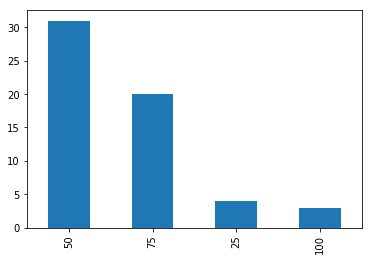

In [17]:
pd.Series([int(m.split('_')[1].replace('features','')) for m in rmse_details_df[rmse_details_df.auc_quartile >= 4].model.tolist()]).value_counts().plot(kind = 'bar');

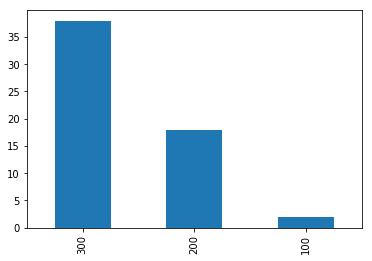

In [16]:
pd.Series([int(m.split('_')[3].replace('epochs','')) for m in rmse_details_df[rmse_details_df.auc_quartile >= 4].model.tolist()]).value_counts().plot(kind = 'bar');

## RMSE Distribution for All Models
Specifically, the last (fourth) predicted period (day-over-day) -- rather than all four predicted periods.

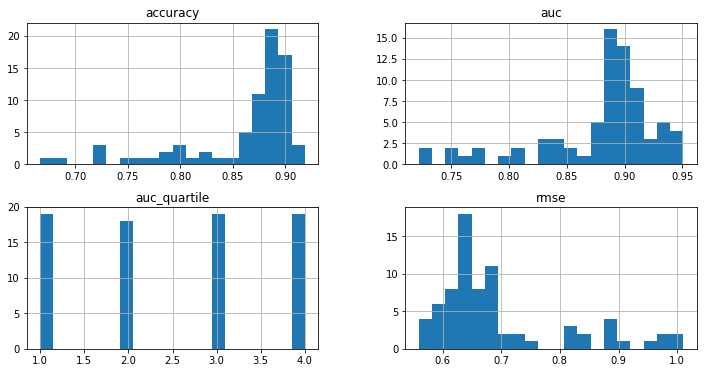

In [16]:
rmse_details_df.hist(bins = 20, figsize = (12, 6));

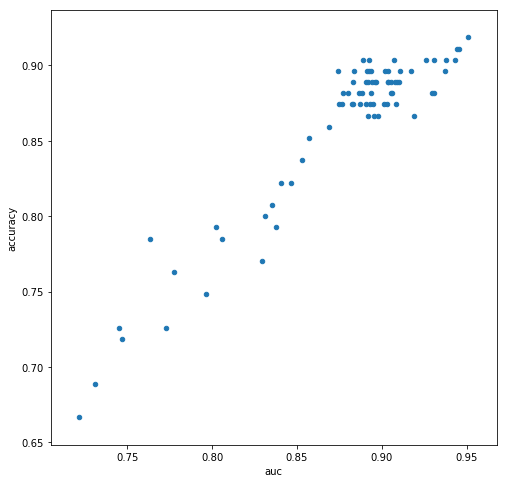

In [17]:
rmse_details_df.plot('auc', 'accuracy', kind = 'scatter', figsize = (8, 8));

## AUC Analysis

In [18]:
auc_quartile_perf_df = rmse_details_df[['auc_quartile',
                                        'auc',
                                        'accuracy',
                                        'dropout',
                                        'epochs',
                                        'features',
                                        'layers',
                                        'units',
                                        'steps']].astype('float')

mean_perf_df = rmse_details_df[['accuracy',
                                'dropout',
                                'epochs',
                                'features',
                                'layers',
                                'units']].astype('float').mean()

auc_quartile_perf_df.groupby('auc_quartile').median()

,auc,accuracy,dropout,epochs,features,layers,units,steps
auc_quartile,,,,,,,,
1.0,0.805909,0.785185,0.2,300.0,50.0,1.0,64.0,5.0
2.0,0.884938,0.881481,0.3,300.0,50.0,1.0,64.0,10.5
3.0,0.896791,0.888889,0.2,300.0,50.0,1.0,96.0,11.0
4.0,0.925658,0.896296,0.2,200.0,50.0,1.0,64.0,13.0


In [19]:
auc_quartile_perf_df.groupby('steps').mean()

,auc_quartile,auc,accuracy,dropout,epochs,features,layers,units
steps,,,,,,,,
2.0,1.000000,0.732576,0.693827,0.133333,266.666667,58.333333,1.0,74.666667
3.0,1.000000,0.760860,0.743210,0.133333,233.333333,66.666667,1.0,74.666667
4.0,1.000000,0.824318,0.782716,0.300000,300.000000,50.000000,1.0,64.000000
5.0,1.000000,0.792069,0.767901,0.233333,266.666667,58.333333,1.0,74.666667
6.0,1.000000,0.835686,0.809877,0.233333,266.666667,50.000000,1.0,74.666667
7.0,1.000000,0.852263,0.837037,0.100000,200.000000,66.666667,1.0,74.666667
8.0,2.333333,0.883663,0.886420,0.233333,266.666667,50.000000,1.0,85.333333
9.0,2.888889,0.895912,0.888066,0.200000,255.555556,58.333333,1.0,78.222222
10.0,2.666667,0.893279,0.880658,0.200000,255.555556,58.333333,1.0,78.222222


In [20]:
auc_quartile_perf_df.groupby('auc_quartile').mean()

,auc,accuracy,dropout,epochs,features,layers,units,steps
auc_quartile,,,,,,,,
1.0,0.803261,0.776998,0.184211,252.631579,59.210526,1.0,75.789474,4.894737
2.0,0.884485,0.883128,0.227778,266.666667,55.555556,1.0,80.000000,10.444444
3.0,0.898281,0.884990,0.205263,257.894737,59.210526,1.0,82.526316,10.842105
4.0,0.924730,0.894737,0.178947,247.368421,57.894737,1.0,70.736842,12.578947


In [21]:
mean_perf_df

accuracy      0.859654
dropout       0.198667
epochs      256.000000
features     58.000000
layers        1.000000
units        77.226667
dtype: float64

## RMSE Analysis

#### Features
As it stands, **the 40 feature models are currently performoing better** in regards to error. We don't have as many 80 feature models though so more data is neeeded.

In [20]:
rmse_details_df.groupby('features').mean().sort_values('accuracy', ascending = False)

,accuracy,auc,rmse,auc_quartile
features,,,,
50,0.872912,0.893699,0.659988,2.607843
75,0.871498,0.882597,0.672076,2.260870


#### Layers
There doesn't seem to be any difference in error using 1 or 2 layers.

In [32]:
print('\n== 25 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '25'].groupby('layers').mean().sort_values('accuracy', ascending = False))

print('\n== 50 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '50'].groupby('layers').mean().sort_values('accuracy', ascending = False))

print('\n== 75 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '75'].groupby('layers').mean().sort_values('accuracy', ascending = False))

print('\n== 100 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '100'].groupby('layers').mean().sort_values('accuracy', ascending = False))


== 25 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 50 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 75 Features ==

        accuracy       auc      rmse
layers                              
1       0.731667  0.783645  0.904201

== 100 Features ==

        accuracy       auc      rmse
layers                              
1       0.727083  0.773847  0.937819


#### LSTM Units
There is a clear preference for **less LSTM units**.

In [33]:
print('\n== 25 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '25'].groupby('units').mean().sort_values('accuracy', ascending = False))

print('\n== 50 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '50'].groupby('units').mean().sort_values('accuracy', ascending = False))

print('\n== 75 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '75'].groupby('units').mean().sort_values('accuracy', ascending = False))

print('\n== 100 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '100'].groupby('units').mean().sort_values('accuracy', ascending = False))


== 25 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 50 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 75 Features ==

       accuracy       auc      rmse
units                              
64     0.737500  0.786768  0.903456
96     0.732500  0.781347  0.911746
128    0.728333  0.783838  0.903171
32     0.728333  0.782626  0.898432

== 100 Features ==

       accuracy       auc      rmse
units                              
96     0.731667  0.769529  0.942719
32     0.728333  0.781178  0.922495
64     0.727500  0.771347  0.937160
128    0.720833  0.773333  0.948901


#### Dropout
Overall, it seems **the lower the dropout the better -- except 0, that performs worst in both 40 and 80 feature models**. There is no *logical* trend for the 80 feature models, need more data before we can say anything conclusive. **For the 40 feature models, dropouts of 0.1 and 0.2 are best**.

In [34]:
print('\n== Overall ==\n')
print(rmse_details_df.groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 25 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '25'].groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 50 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '50'].groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 75 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '75'].groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 100 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '100'].groupby('dropout').mean().sort_values('accuracy', ascending = False))


== Overall ==

         accuracy       auc      rmse
dropout                              
0        0.732083  0.785758  0.913639
0.4      0.730417  0.777677  0.926945
0.2      0.730000  0.778620  0.925504
0.6      0.725000  0.772929  0.917952

== 25 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 50 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 75 Features ==

         accuracy       auc      rmse
dropout                              
0        0.742500  0.791010  0.888460
0.4      0.733333  0.782694  0.911738
0.2      0.727500  0.785421  0.909328
0.6      0.723333  0.775455  0.907278

== 100 Features ==

         accuracy       auc      rmse
dropout                              
0.2      0.732500  0.771818  0.941680
0.4      0.727500  0.772660  0.942151
0.6      0.726667  0.770404  0.928627
0        0.721667  0.780505  0.938819


#### Epochs
May not be relevant in every situtation, but...

In [35]:
print('\n== 25 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '25'].groupby('epochs').mean().sort_values('accuracy', ascending = False))

print('\n== 50 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '50'].groupby('epochs').mean().sort_values('accuracy', ascending = False))

print('\n== 75 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '75'].groupby('epochs').mean().sort_values('accuracy', ascending = False))

print('\n== 100 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '100'].groupby('epochs').mean().sort_values('accuracy', ascending = False))


== 25 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 50 Features ==

Empty DataFrame
Columns: [accuracy, auc, rmse]
Index: []

== 75 Features ==

        accuracy       auc      rmse
epochs                              
300     0.749375  0.795707  0.911938
200     0.727500  0.788712  0.901323
100     0.718125  0.766515  0.899342

== 100 Features ==

        accuracy       auc      rmse
epochs                              
100     0.729375  0.764773  0.906860
200     0.728750  0.778131  0.938473
300     0.723125  0.778636  0.968124


# Find Optimal Ensemble

## Define Iterables

In [22]:
#summary.model.tolist()
#rmse_details_df[(rmse_details_df.rmse <= 0.055) & (rmse_details_df.accuracy >= 0.72)].model.tolist()

In [23]:
rmse_details_df.sort_values('accuracy', ascending = False)

,accuracy,dropout,epochs,features,layers,model,rmse,units
15,0.79,0,200,75,1,24hrs_75features_1layers_200epochs_1timesteps_...,0.838754,64
32,0.78,0,300,75,1,24hrs_75features_1layers_300epochs_1timesteps_...,0.847065,64
11,0.77,0,300,75,1,24hrs_75features_1layers_300epochs_1timesteps_...,0.900282,96
69,0.76,0.2,100,100,1,24hrs_100features_1layers_100epochs_1timesteps...,0.911644,96
67,0.76,0.2,300,75,1,24hrs_75features_1layers_300epochs_1timesteps_...,0.901321,128
14,0.76,0.2,300,75,1,24hrs_75features_1layers_300epochs_1timesteps_...,0.921243,32
68,0.76,0.4,200,75,1,24hrs_75features_1layers_200epochs_1timesteps_...,0.886925,32
24,0.76,0,300,75,1,24hrs_75features_1layers_300epochs_1timesteps_...,0.913355,128
53,0.76,0.2,100,100,1,24hrs_100features_1layers_100epochs_1timesteps...,0.903097,128
6,0.76,0.4,200,75,1,24hrs_75features_1layers_200epochs_1timesteps_...,0.891731,96


## Get Ensemble Combinations

In [27]:
'''
DON'T FORGET TO SET THIS
'''''''''

max_models_per_ensemble = 5

''''''''''''

''

In [28]:
# create a range for iteration
iter_models = np.arange(len(all_models))

subsets = []

iter_model_sum = int(len(iter_models))
iter_model_list = list(iter_models)

for L in range(0, max_models_per_ensemble + 1):
    print('starting iteration:', L)
    for subset in combinations(iter_model_list, L):
        subsets.append(subset)

# get rid of first item (empty)
subsets = list(subsets[1:])

print('\nThere are %s possible ensembles total!' % len(subsets))

starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5

There are 5038953 possible ensembles total!


## Get Accuracy & Error for Each Ensemble
 .

In [1]:
counter = 0

ens_coms = []
ens_accs = []
ens_aucs = []
ens_rmse_all = []
ens_rmse_tar = []

for subset in subsets:

    # get all model combos based off of subset index
    model_combo = [all_models[sub] for sub in subset]

    model_predicted = {}
    model_error = {}

    for m in model_combo:
        model_predicted[m] = [p[0][1] for p in results[m]]
        #model_error[m] = [p[1][1] for p in results[m]]

    match_count = 0
    match_list_plot_ps = []

    # create a series of the actual and predicted values
    y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
    y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
    
    # create a zip using the true and predicted values
    ensemble_zip_acc = zip(y_true, y_pred)

    # create a series of the RMSE (of each predicted step, using in training calcs)
    #m_rmse = pd.DataFrame(model_error).mean(1)
    
    # get auc for binary classification problems
    auc = roc_auc_score(y_true, y_pred)

    # get the RMSE of only the target (the fourth time period, or next day)
    rmse_target = mse(y_true, y_pred) ** (0.5)
    
    # get the sign accuracy count of the predictions
    for a, p in ensemble_zip_acc:

        if np.sign(p) == np.sign(a): match_count += 1

        if np.sign(p) == np.sign(a):
            match_list_plot_ps.append(0.1)
        else:
            match_list_plot_ps.append(-0.1)

    # calculate the overall accuracy
    ensemble_acc = match_count / len(pd.DataFrame(model_predicted).mean(1).tolist())

    ens_coms.append(str(model_combo))
    ens_accs.append(ensemble_acc)
    ens_aucs.append(auc)
    #ens_rmse_all.append(m_rmse.mean())
    ens_rmse_tar.append(rmse_target)

    counter += 1

    if counter % 10000 == 0: print('%s done' % counter)

## General Ensemble Analysis

In [30]:
print('mean:', np.mean(model_y_true[list(model_y_true.keys())[0]]))

mean: -0.1


In [31]:
combo_results_df = pd.DataFrame({'combo': ens_coms,
                                 'accuracy': ens_accs,
                                 'auc': ens_aucs,
                                 #'rmse_all': ens_rmse_all,
                                 'rmse_tar': ens_rmse_tar,}).drop_duplicates('combo').sort_values('accuracy',
                                                                                                  ascending = False
                                                                                                 ).reset_index(drop = True)

In [35]:
combo_results_df.sort_values('auc', ascending = False)

,accuracy,auc,combo,rmse_tar
1015238,0.77,0.859798,['24hrs_75features_1layers_200epochs_1timestep...,0.818440
703353,0.78,0.859798,['24hrs_75features_1layers_200epochs_1timestep...,0.814456
1011899,0.77,0.859394,['24hrs_75features_1layers_200epochs_1timestep...,0.820018
141710,0.79,0.858990,['24hrs_75features_1layers_200epochs_1timestep...,0.812063
1962727,0.77,0.858990,['24hrs_75features_1layers_200epochs_1timestep...,0.823704
2112698,0.77,0.858990,['24hrs_75features_1layers_200epochs_1timestep...,0.826981
703136,0.78,0.858586,['24hrs_75features_1layers_200epochs_1timestep...,0.818940
3194148,0.76,0.858586,['24hrs_75features_1layers_200epochs_1timestep...,0.816102
3225189,0.76,0.858586,['24hrs_75features_1layers_200epochs_1timestep...,0.814724
702761,0.78,0.858586,['24hrs_75features_1layers_200epochs_1timestep...,0.816294


In [2]:
combo_results_df[['accuracy', 'auc']].plot(kind = 'scatter', x = 'accuracy', y = 'auc');

In [47]:
high_acc_ens = combo_results_df[combo_results_df.accuracy >= .82].combo.tolist()

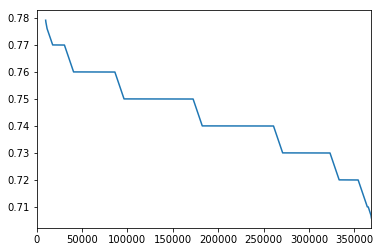

In [40]:
# rolling average of ensemble accuracy
combo_results_df.accuracy.reset_index(drop = True).rolling(center = False, window = 10000).mean().plot();

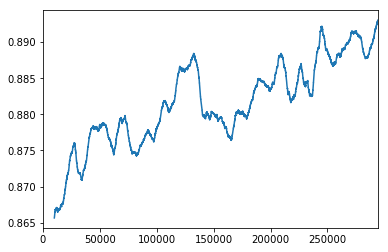

In [46]:
# rolling average of ensemble error
combo_results_df.rmse_tar.reset_index(drop = True).rolling(center = False, window = 10000).mean().plot();

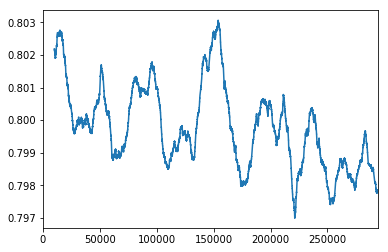

In [47]:
# rolling average of ensemble error
combo_results_df.auc.reset_index(drop = True).rolling(center = False, window = 10000).mean().plot();

In [91]:
for m in top_clf_ens_1:
    model_predicted[m] = [p[0][1] for p in results[m]]

y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
y_true = [i[0][0] for i in results[model_combo[0]]]

# Find Best Trading Strategy for Top Ensembles

In [19]:
# set trading strategies
trading_strategies = ['static_target_threshold',
                      'static_target_always',
                      'variable_target_threshold',
                      'variable_target_always',
                      'no_target_threshold',
                      'no_target_always'
                     ]

In [2]:
'''
FIND THE MOST PROFITABLE THRESHOLD USING THE TOP MODELS
'''

all_accs = {}
all_laac = {}
all_prfs = {}
all_marg = {}
all_prtr = {}
all_lotr = {}
all_rmse = {}

#####
# SET MIN & MAX
##

min_target = 0
max_target = 0.175
target_step = 0.005

for strat_type in trading_strategies:
    
    print('starting', strat_type)
    
    for trade_target in np.arange(min_target, max_target, target_step):
        
        strategy_id = '%s_%s' % (strat_type, trade_target)
        
        ens_coms = []
        ens_accs = []
        ens_laac = []
        ens_prfs = []
        ens_marg = []
        ens_prtr = []
        ens_lotr = []
        ens_rmse = []
        
        print(strategy_id)

        for model_combo in high_acc_ens:

            if len(model_combo) > 0:

                model_predicted = {}
                model_error = {}

                for m in model_combo:
                    model_predicted[m] = [p[0][1] for p in results[m]]
                    model_error[m] = [p[1] for p in results[m]]

                match_count = 0
                match_list_plot_ps = []

                # create a series of the actual and predicted values
                y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
                y_pred = pd.DataFrame(model_predicted).mean(1).tolist()

                # create a series of the RMSE
                m_rmse = pd.DataFrame(model_error).mean(1)

                # create a zip using the true and predicted values, there needs to be two
                # because for some reason, a zip can only be used once
                ensemble_zip_acc = zip(y_true, y_pred)
                ensemble_zip_cap = zip(y_true, y_pred)

                # get the sign accuracy count of the predictions
                for a, p in ensemble_zip_acc:

                    if np.sign(p) == np.sign(a): match_count += 1

                    if np.sign(p) == np.sign(a):
                        match_list_plot_ps.append(0.1)
                    else:
                        match_list_plot_ps.append(-0.1)

                # calculate the overall accuracy
                ensemble_acc = match_count / len(pd.DataFrame(model_predicted).mean(1).tolist())
                
                # calculate the lag accuracy
                ensemble_lag_acc = get_lag_accuracy(y_true, y_pred)
                
                # run the predictions through a trade simulation
                ensemble_cap = target_trading_simulation(ensemble_zip_cap, strat_type, 1000, trade_target)

                ens_coms.append(str(model_combo))
                ens_accs.append(ensemble_acc)
                ens_laac.append(ensemble_lag_acc)
                ens_prfs.append(ensemble_cap[0])
                ens_marg.append(ensemble_cap[1])
                ens_prtr.append(ensemble_cap[2])
                ens_lotr.append(ensemble_cap[3])
                ens_rmse.append(m_rmse.mean())
         
        # add performance to list to judge target threshold
        all_accs[strategy_id] = list(ens_accs)
        all_laac[strategy_id] = list(ens_laac)
        all_prfs[strategy_id] = list(ens_prfs)
        all_marg[strategy_id] = list(ens_marg)
        all_prtr[strategy_id] = list(ens_prtr)
        all_lotr[strategy_id] = list(ens_lotr)
        all_rmse[strategy_id] = list(ens_rmse)

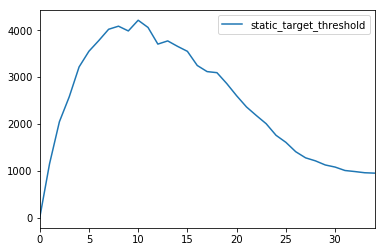

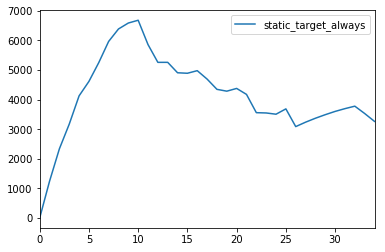

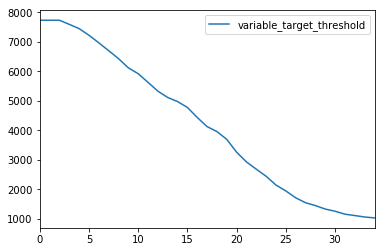

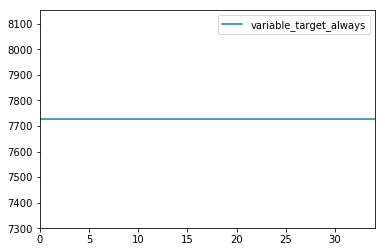

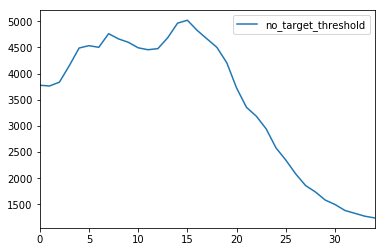

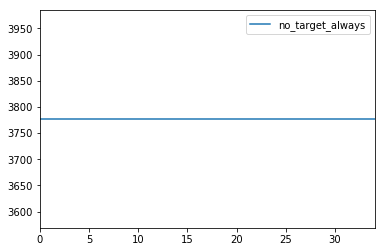

In [52]:
for strat_type in trading_strategies:
    
    sids = []
    
    for trade_target in np.arange(min_target, max_target, target_step):
        strategy_id = '%s_%s' % (strat_type, trade_target)
        sids.append(strategy_id)
    
    pd.DataFrame({strat_type: pd.DataFrame([all_marg[sid] for sid in sids]).T.mean().values}).plot(legend = True)

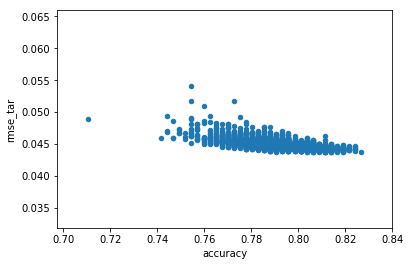

In [56]:
# ONCE TRADE STRATEGY IS DECIDED, DO A SCATTER BETWEEN ACCURACY AND PROFIT

combo_results_df.plot('accuracy', 'rmse_tar', kind = 'scatter');

# TRENDED VOLATALITY

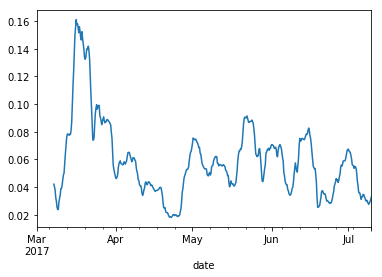

In [23]:
'''
GET TRENDED VOLATALITY SINCE TRAINING DATA START
'''

# get all attributes for the 6hr candle
candle_time = '6H'
df = ta.get_all_attributes('BTC_ETH', candle_time)

# extract only close price
close = pd.DataFrame({'close': df.close})

# get the next day price and drop null values
close['next_day_close'] = close.shift(-4)
close.dropna(inplace = True)

# set RoC
close['roc'] = (close['next_day_close'] - close['close']) / close['close']

# drop any data before March
tp = close[close.index >= '2017-03-01']

# get absolute value for a better volatality measure
tp['abs_roc'] = abs(tp['roc'])

# plot the ema, with a 28 period (1 wk) window
tp.abs_roc.rolling(window = 28).mean().plot();

# PREDICTION THRESHOLD ACCURACY

In [19]:
'''
GET TRENDED VOLATALITY SINCE TRAINING DATA START
'''

y_pred_dict = {}

for m in results:
    
    y_pred_dict[m] = [r[0][1] for r in results[m]]
    y_true_list = [r[0][0] for r in results[m]]

ens_y_pred = pd.DataFrame(y_pred_dict)[ens_model_list].mean(1).tolist()

ens_results = pd.DataFrame({'ens_y_pred': ens_y_pred, 'ens_y_true': y_true_list})

ens_results['accurate'] = np.sign(ens_results['ens_y_pred']) == np.sign(ens_results['ens_y_true'])

In [25]:
ens_results.groupby('accurate').mean()

,ens_y_pred,ens_y_true
accurate,,
False,0.003618,0.002202
True,0.017902,0.028005


In [24]:
ens_results.groupby('accurate').median()

,ens_y_pred,ens_y_true
accurate,,
False,0.004036,-0.003147
True,0.007719,0.021392


In [55]:
# helper to get volatality threshold / category
def get_volatality(row):
    
    # get absolute values
    v = abs(row['ens_y_pred'])
    
    # categorize the level of volatality
    for level in np.arange(0.01, .3, 0.005).tolist():
        if v < level:
            return level

# calculate volatality level
ens_results['volatality_level'] = ens_results.apply(lambda x: get_volatality(x), axis = 1)

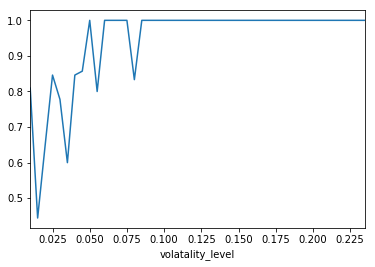

In [57]:
ens_results.groupby('volatality_level').mean().accurate.plot();

In [58]:
ens_results.groupby('volatality_level').mean()

,ens_y_pred,ens_y_true,accurate
volatality_level,,,
0.010,0.002606,0.010498,0.809524
0.015,-0.002998,-0.009029,0.444444
0.020,0.000936,0.019837,0.647059
0.025,-0.004445,0.004728,0.846154
0.030,0.006150,0.016796,0.777778
0.035,-0.006984,-0.015291,0.600000
0.040,0.008618,0.024640,0.846154
0.045,-0.006575,-0.004635,0.857143
0.050,-0.015062,0.012013,1.000000


# Period Lag Predictions

In [26]:
print('MOST ACCURATE\n')
print(top_ens_1)

print('\nLOWEST ERROR\n')
print(top_ens_2)

In [65]:
sample = results['80features_2layers_300epochs_1timesteps_0dropout_96units']

In [66]:
y_true = [s[0][0] for s in sample]
y_pred = [s[0][1] for s in sample]

# FIND THE MOST PROFITABLE TRADING STRATEGY

In [95]:
df = pd.read_csv('btceth_export_2017-07-16.csv')

# filter down to new df with only the needed cols and dates
df.index = df.date
ema_cols = [col for col in df if 'ema' in col and 'roc' in col]
df = df[ema_cols + ['close', 'close_target']]

# the start date of the predicted data is:
df = df[df.index >= '2017-04-11 12:00:00']

# ending after 379 samples
df = df.ix[:379,:]

trend_df = pd.DataFrame()

# create new df with the sign of each dimension
for col in df.columns.tolist():
    
    # get the sign of each roc
    trend_df[col] = np.sign(df[col])

# add y values to the cycle / sign df
trend_df['y_true'] = np.array(y_true[:379])
trend_df['y_pred'] = np.array(y_pred[:379])

# add a filler col for no trend for easier iteration in analysis
trend_df['no_trend'] = 0

In [3]:
'''
FIND THE MOST PROFITABLE TRADING STRATEGY
'''

all_prfs = {}
all_marg = {}
all_prtr = {}
all_lotr = {}

#####
# SET MIN & MAX
##

min_target = 0
max_target = 0.18
target_step = 0.0025

# all n period RoC ema and a 'no trend' option
trend_cols = [col for col in trend_df if 'ema' in col] + ['no_trend']

for strat_type in trading_strategies:
    
    print('starting', strat_type)
    
    for trade_target in np.arange(min_target, max_target, target_step):
        
        for trend in trend_cols:
            
            strategy_id = '%s|%s|%s' % (strat_type, trade_target, trend)
            print(strategy_id)
            
            ens_coms = []
            ens_prfs = []
            ens_marg = []
            ens_prtr = []
            ens_lotr = []
            
            # get the list of trend lists for the trading simulation
            trend_class = trend_df[trend].tolist()
            
            counter = 0
            
            for model_combo in high_acc_ens:
                
                if len(model_combo) > 0:
                    
                    model_predicted = {}
                    
                    for m in model_combo:
                        model_predicted[m] = [p[0][1] for p in results[m]]
                    
                    match_count = 0
                    match_list_plot_ps = []
                    
                    # create a series of the actual and predicted values
                    y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
                    y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
                    
                    # create a zip using the true and predicted values, there needs to be two
                    # because for some reason, a zip can only be used once
                    ensemble_zip_cap = zip(y_true, y_pred)
                    
                    if trend != 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = trend_trading_simulation(ensemble_zip_cap,
                                                                strat_type,
                                                                1000,
                                                                trade_target,
                                                                trend_class
                                                               )
                    
                    elif trend == 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = target_trading_simulation(ensemble_zip_cap,
                                                                 strat_type,
                                                                 1000,
                                                                 trade_target
                                                                )
                    
                    else: print('\n\n\nSOMETHING IS WRONG!!!\n\n\n')
                        
                    # add results to each ensemble's kpi list
                    ens_coms.append(str(model_combo))
                    ens_prfs.append(ensemble_cap[0])
                    ens_marg.append(ensemble_cap[1])
                    ens_prtr.append(ensemble_cap[2])
                    ens_lotr.append(ensemble_cap[3])

            # add performance to list to judge target threshold
            all_prfs[strategy_id] = list(ens_prfs)
            all_marg[strategy_id] = list(ens_marg)
            all_prtr[strategy_id] = list(ens_prtr)
            all_lotr[strategy_id] = list(ens_lotr)

In [107]:
avg_perf = []

for k in all_prfs:
    
    avg_perf.append({'zid': k,
                     'trading_strategy': k.split('|')[0],
                     'target_threshold': k.split('|')[1],
                     'market_trend': k.split('|')[2],
                     'profit': np.array(all_prfs[k]).mean(),
                     'marg_return': np.array(all_marg[k]).mean(),
                     'profitable_trade_count': np.array(all_prtr[k]).mean(),
                     'loss_trade_count': np.array(all_lotr[k]).mean()
                    }
                   )

avg_perf_df = pd.DataFrame(avg_perf).sort_values('marg_return', ascending = False).reset_index(drop = True)

In [112]:
avg_perf_df.head(10)

,loss_trade_count,marg_return,market_trend,profit,profitable_trade_count,target_threshold,trading_strategy,zid
0,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1425,no_target_always,no_target_always|0.1425|roc_ema_180_5
1,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.01,no_target_always,no_target_always|0.01|roc_ema_180_5
2,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1075,no_target_always,no_target_always|0.1075|roc_ema_180_5
3,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.0825,no_target_always,no_target_always|0.0825|roc_ema_180_5
4,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1675,no_target_always,no_target_always|0.1675|roc_ema_180_5
5,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1275,no_target_always,no_target_always|0.1275|roc_ema_180_5
6,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1725,no_target_always,no_target_always|0.1725|roc_ema_180_5
7,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.035,no_target_always,no_target_always|0.035|roc_ema_180_5
8,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.14,no_target_always,no_target_always|0.14|roc_ema_180_5
9,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.145,no_target_always,no_target_always|0.145|roc_ema_180_5


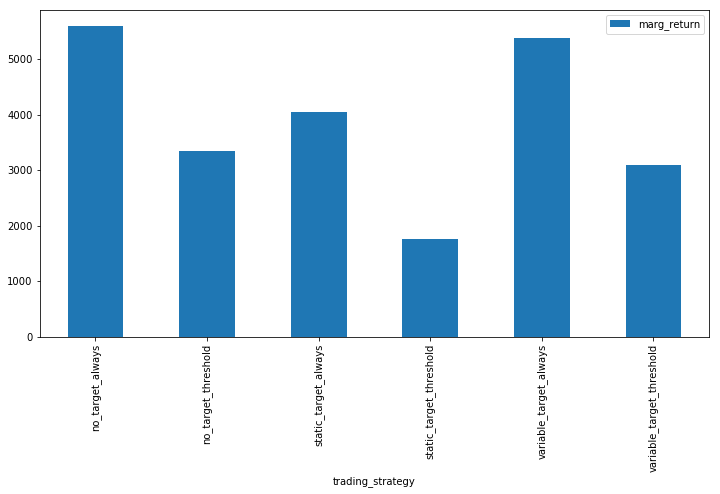

In [132]:
avg_perf_df[['market_trend',
             'trading_strategy',
             'marg_return']].groupby(['trading_strategy']).mean().plot(kind = 'bar',
                                                                   figsize = (12, 6)
                                                                  );

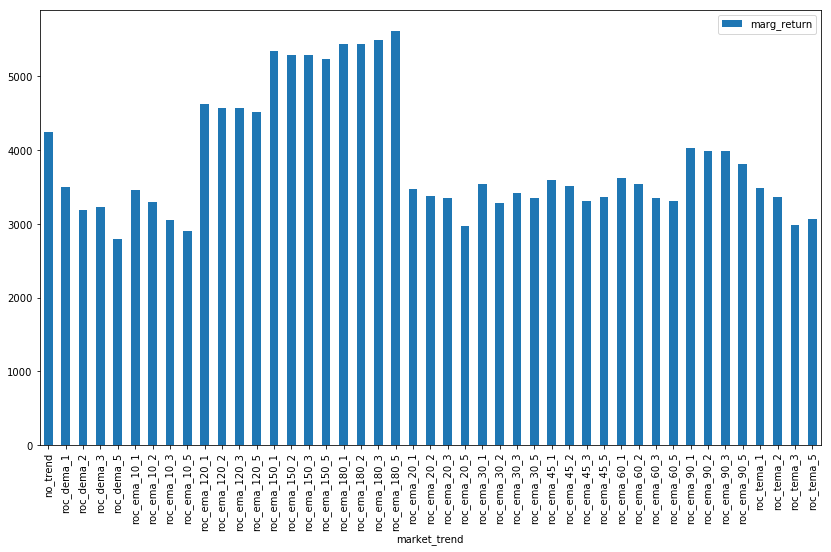

In [129]:
avg_perf_df[['market_trend',
             'trading_strategy',
             'marg_return']].groupby(['market_trend']).mean().plot(kind = 'bar',
                                                                   figsize = (14, 8)
                                                                  );

static_target_threshold
variable_target_threshold
no_target_always
no_target_threshold
static_target_always
variable_target_always


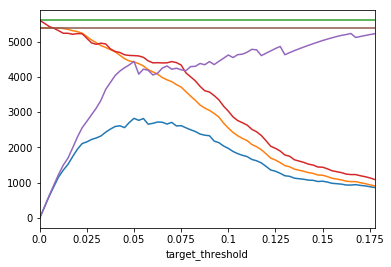

In [109]:
for s in set(avg_perf_df.trading_strategy.tolist()):
    
    print(s)
    
    select_ts = avg_perf_df.trading_strategy == s
    #select_mt = avg_perf_df.market_trend == 'roc_ema_150_1'
    
    sdf = avg_perf_df[select_ts].sort_values('target_threshold')
    #sdf = avg_perf_df[(select_ts) & (select_mt)].sort_values('target_threshold')
    
    sdf.groupby('target_threshold').mean().marg_return.plot()

## Trading Strategy Notes

Basically, the best strategy is to open a position in the direction of the trend any time the model predicts that's the way it will go. Which is probably the easiest strategy to follow, well kinda. Mentally it will be tough. But it leaves little room for compromise, so that's good.

**Next steps are**:
 - run the final iteration of the enemble finder with the remainding models
 - get the predictions for the period of time since i started testing and run the best models
 - see if the trading strategy holds
 - finish up with the lag accuracy stuff
 - go back to following Trello

# TRENDED MARGIN RETURN

In [130]:
# set trading strategies
trading_strategies = [
    
    'static_target_threshold',
    'static_target_always',
    'variable_target_threshold',
    'variable_target_always',
    'no_target_threshold',
    'no_target_always'

]

# set trend strategies

trend_strategies = [
    
    'roc_ema_180_5',
    'no_trend'
]

In [131]:
for m in top_ens_1:
    model_predicted[m] = [p[0][1] for p in results[m]]

y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
y_true = model_y_true[list(results.keys())[0]]

ema_180_5_trend_class = trend_df.roc_ema_180_5.tolist()

In [135]:
# set per len
per_step = 14

# set min, max, step
min_target = 0.0001
max_target = 0.15
target_step = 0.0001

# all n period RoC ema and a 'no trend' option
#trend_cols = [col for col in trend_df if 'ema' in col] + ['no_trend']

strat_trended = {}
per_range = np.arange(0, len(y_pred), per_step)

for trend in trend_strategies:
    
    # get the list of trend lists for the trading simulation
    trend_class = trend_df[trend].tolist()

    for strat_type in trading_strategies:
        
        strat_id = strat_type + '_' + trend

        print('starting', strat_id)

        target_return = {}

        for trade_target in np.arange(min_target, max_target, target_step):

            start_index = 0
            end_index = 1

            trended_return = []

            for _ in per_range:

                try:

                    start_slice = per_range[start_index]
                    end_slice = per_range[end_index]

                    # (re)zip y values
                    ensemble_zip_cap = zip(y_true[start_slice:end_slice],
                                           y_pred[start_slice:end_slice]
                                          )

                    # add to indices for next iteration
                    start_index += 1
                    end_index += 1
                    
                    if trend == 'no_trend':
                    
                        # run the predictions through a trade simulation
                        ensemble_cap = target_trading_simulation(ensemble_zip_cap,
                                                                 strat_type,
                                                                 1000,
                                                                 trade_target
                                                                )
                        
                    elif trend != 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = trend_trading_simulation(ensemble_zip_cap,
                                                                strat_type,
                                                                1000,
                                                                trade_target,
                                                                trend_class
                                                               )
                        
                    # add the return to the list for this target
                    trended_return.append(ensemble_cap[1])

                except IndexError: pass

            target_return[trade_target] = trended_return

        strat_trended[strat_id] = pd.DataFrame(target_return).mean(1).tolist()

starting static_target_threshold_roc_ema_180_5
starting static_target_always_roc_ema_180_5
starting variable_target_threshold_roc_ema_180_5
starting variable_target_always_roc_ema_180_5
starting no_target_threshold_roc_ema_180_5
starting no_target_always_roc_ema_180_5
starting static_target_threshold_no_trend
starting static_target_always_no_trend
starting variable_target_threshold_no_trend
starting variable_target_always_no_trend
starting no_target_threshold_no_trend
starting no_target_always_no_trend


In [136]:
trended_return_df = pd.DataFrame(strat_trended)
trended_return_df['baseline'] = 0

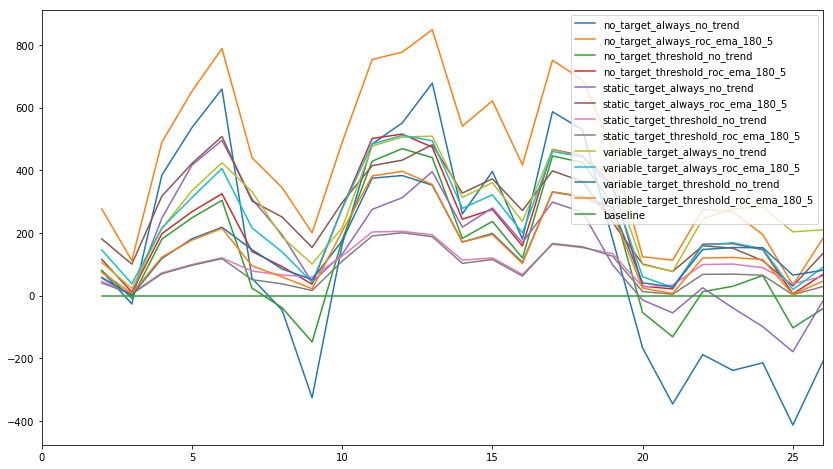

In [137]:
trended_return_df.rolling(3).mean().plot(figsize = (14, 8));

In [138]:
# what percentage of the most recent time periods
recent_percentage = 0.2

print('\n===== TOP PERFORMING STRATEGIES, RECENTLY =====')
trended_return_df[trended_return_df.index >= (len(trended_return_df.index) * (1 - recent_percentage))].sum().sort_values(ascending = False)


===== TOP PERFORMING STRATEGIES, RECENTLY =====


variable_target_always_no_trend            1330.689387
no_target_always_roc_ema_180_5             1108.624004
static_target_always_roc_ema_180_5          714.458517
variable_target_always_roc_ema_180_5        706.939543
variable_target_threshold_no_trend          668.507574
no_target_threshold_roc_ema_180_5           640.397619
variable_target_threshold_roc_ema_180_5     481.006811
static_target_threshold_no_trend            430.997994
static_target_threshold_roc_ema_180_5       279.889364
no_target_threshold_no_trend                129.204719
baseline                                      0.000000
static_target_always_no_trend              -155.168806
no_target_always_no_trend                  -914.313530
dtype: float64